# Finding the most representative GWAS associated with cell-specific enhancers
# (Execution on Google Cloud File System)

In this tutorial we are going to use a GWAS dataset (accessible from [this link](https://www.ebi.ac.uk/gwas/api/search/downloads/full)) together with the whole ENCODE BroadPeak dataset to find which mutations (and their associated traits) are most represented in enhancer regions which are present in a limited set of cells.

As first thing let's download the data.

In [ ]:
%%bash

wget -q https://www.ebi.ac.uk/gwas/api/search/downloads/full -O tmp.tsv
cat tmp.tsv | \
    awk 'BEGIN {FS="\t";OFS="\t"} {chrom=$12; gsub(chrom,"chr"chrom,$12)}{print $0}' | \
    sed s/,//g > gwas.tsv
rm tmp.tsv

In [28]:
myBucket = "gs://fc-cad72548-2d6b-41ce-82aa-975cb7e8b764"

In order to run the query on HDFS, we have to put the file there. We will use the bucket for this Terra Notebook.

In [ ]:
!gsutil cp ./gwas.tsv $myBucket/

## Library imports

In [3]:
import gmql as gl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Setting the master of the cluster

In this example, the data reside in the HDFS of the spark cluster. Let's say that the cluster is managed by the YARN resource manager. We have therefore to tell PyGMQL to use it.

In [4]:
gl.set_master("yarn")

## Loading of the GWAS dataset

In this example, we have loaded the GMQL repository on the Google Cloud Storage. It is convenient to store in a variable the path of the repository.

In [1]:
gmql_repository = "gs://geco_repository/"
gwas_path = myBucket + "/gwas.tsv"

The GWAS data comes from a single TSV file. Therefore we can import it using the `load_from_file` function.
Notice that we have to specify a `parser` to properly load our data. Therefore it is wise to take a look at the schema of the downloaded file.

We are mainly interested in the mutation position (11-th and 12-th column) and the associated trait (7-th).

In [5]:
gwas = gl.load_from_file(gwas_path, 
                         parser=gl.parsers.RegionParser(
                             chrPos=11, 
                             startPos=12, 
                             stopPos=12, 
                             otherPos=[(7, "trait", 'string')]))

### Inspecting the dataset
We can load a tiny part of the dataset to make sense of the data types and schema. You can inspect the dataset using the `head` function. This function returns a `GDataframe` object, which enables the access to regions (`regs`) and metadata (`meta`)

In [6]:
gwas.head().regs

100%|██████████| 2/2 [00:00<00:00, 820.40it/s]


,chr,start,stop,strand,trait
id_sample,,,,,
8292134920041699140,chr14,75539214,75539214,*,Multiple sclerosis
8292134920041699140,chr1,200912467,200912467,*,Multiple sclerosis
8292134920041699140,chr3,119501087,119501087,*,Multiple sclerosis
8292134920041699140,chr11,61064810,61064810,*,Multiple sclerosis
8292134920041699140,chr1,116558335,116558335,*,Multiple sclerosis


We can also simply look at the schema

In [7]:
gwas.schema

['trait', 'chr', 'start', 'stop', 'strand']

### Plotting the traits

We want to get an idea of the trait distribution. In order to do that we have to load the data in memory. Thereofre we can call the `materialize` function and take the regions.

In [8]:
gwas_data = gwas.materialize().regs

100%|██████████| 2/2 [00:00<00:00, 787.96it/s]


We now plot the number of regions for each of the top 30 represented traits.

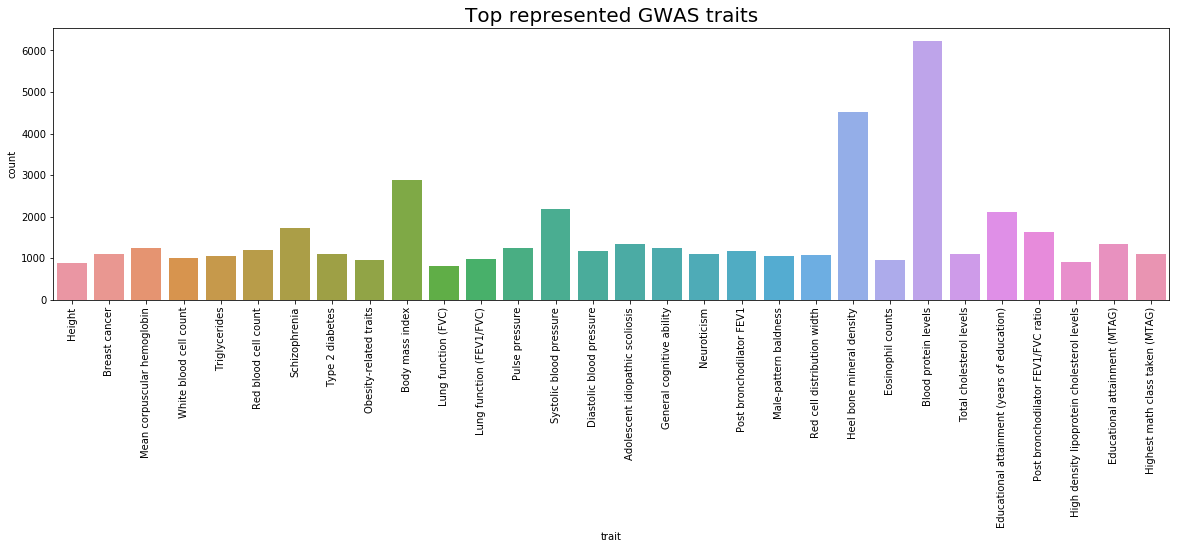

In [9]:
plt.figure(figsize=(20,5))
sns.countplot(data=gwas_data[gwas_data.trait.isin(
        gwas_data.trait.value_counts().iloc[:30].index)], x='trait')
plt.xticks(rotation=90)
plt.title("Top represented GWAS traits", fontsize=20)
plt.show()

## Loading of the ENCODE BroadPeak dataset

We now load the ENCODE BroadPeak dataset.

If the data come already in the GDM format, they can be loaded using the `load_from_path` function. A GDM dataset is stored as a folder having the following structure:

```
/path/to/dataset/:
    - sample1.gdm
    - sample1.gdm.meta
    - sample2.gdm
    - sample2.gdm.meta
    - ...
    - schema.xml
```

The first dataset we load is the one from the GWAS study.

In [10]:
broad = gl.load_from_path(gmql_repository + "HG19_ENCODE_BROAD/")

In [11]:
broad.schema

['name',
 'score',
 'signal',
 'pvalue',
 'qvalue',
 'chr',
 'start',
 'stop',
 'strand']

### Getting the enhancers

We identify enhancers thanks to the presence of H3K27ac peaks. We therefore select all acetylation peaks from ENCODE thanks to the `experiment_target` metadata attribute.

In [12]:
acetyl = broad[broad['experiment_target'] == 'H3K27ac-human']

We get the peak region of the Chip-Seq using the `reg_project` function. The peak position (`peak`) is given by the center of the region.

$$
    peak = \frac{right + left}{2}
$$

In [13]:
peaked = acetyl.reg_project(new_field_dict={
        'peak': acetyl.right/2 + acetyl.left/2})

Once we have the peak, we extend the search region to $\pm 1500 bp$. We use again `reg_project`

In [14]:
enlarge = peaked.reg_project(new_field_dict={
    'left': peaked.peak - 1500, 
    'right': peaked.peak + 1500})

### Grouping by cell line and aggregating the signals

We are interested in enhancers which are cell specific. Therefore it is important to group our data by cell line. In addition to this we merge the signals coming from different tracks for the same cell line. We can do both of these actions using the `normal_cover` function.

In [15]:
enhancers_by_cell_line = enlarge.normal_cover(1, "ANY", 
                                              groupBy=['biosample_term_name'])

To select only the cell-specific enhancers we can now apply again `normal_cover` and constraining the maximum number of overlaps between the regions to be a selected threshold.
In this case we select a threshold of 2.

In [16]:
max_overlapping = 2
cell_specific_enhancers = enhancers_by_cell_line.normal_cover(1, max_overlapping)

In [17]:
cell_specific_enhancers.schema

['AccIndex',
 'JaccardIntersect',
 'JaccardResult',
 'chr',
 'start',
 'stop',
 'strand']

In [18]:
cell_specific_enhancers_by_cell_line = enhancers_by_cell_line.join(
                                    cell_specific_enhancers, 
                                    [gl.DLE(0)], 'left', 
                                    refName="en", expName="csen")

## Mapping mutations to cell specific enhancers

We now map the mutations in the GWAS dataset on the enhancer regions. We store the list of traits associated to each enhancer using the `gl.BAG` expression.

In [19]:
gwas.schema

['trait', 'chr', 'start', 'stop', 'strand']

In [20]:
enhancer_gwas = cell_specific_enhancers_by_cell_line.map(
                        gwas, refName="csen", expName="gwas", 
                        new_reg_fields={'traits': gl.BAG('trait')})
enhancer_gwas = enhancer_gwas.reg_project(
                    ["count_csen_gwas", "traits"],
                    new_field_dict={'cell_line': enhancer_gwas['csen.en.biosample_term_name','string']})

## Materializing the result
We now can call the `materialize` function to execute the full query. The result will be collected in a `GDataframe` object.

In [21]:
enhancer_gwas = enhancer_gwas.materialize()

100%|██████████| 70/70 [00:00<00:00, 159.49it/s]

The `traits` column of the resulting region is the list of traits associated with the cell specific enhancer. The data comes in the form of a string of trait names.
We convert the string to a list.

In [24]:
enhancer_gwas.regs['traits'] = enhancer_gwas.regs.traits\
                                .map(lambda x: x.split(",") if pd.notnull(x) else x)

## Analysis
The final part of the analysis regards the matching of cell lines and traits. We want to understand if a cell line (which is represented by its specific enhancers) has some particular mutation trait associated.
The analysis is performed in Pandas using the result region attributes `traits` and `cell_line`.

We build an association matrix between cell lines and traits by firstly converting the result to a list of `(cell_line, trait)`, converting it to a Pandas DataFrame, and finally using the `crosstab` Pandas function to extract the matrix.

In [25]:
cell_trait = pd.DataFrame.from_records([(k, v) for k, vs in enhancer_gwas.regs[enhancer_gwas.regs.count_csen_gwas > 0]\
                                        .groupby("cell_line").traits.sum().to_dict().items() for v in vs], 
                                       columns=['cell_line', 'trait'])

In [26]:
cross = pd.crosstab(cell_trait.cell_line, cell_trait.trait)

We finally plot the result as an heatmap.

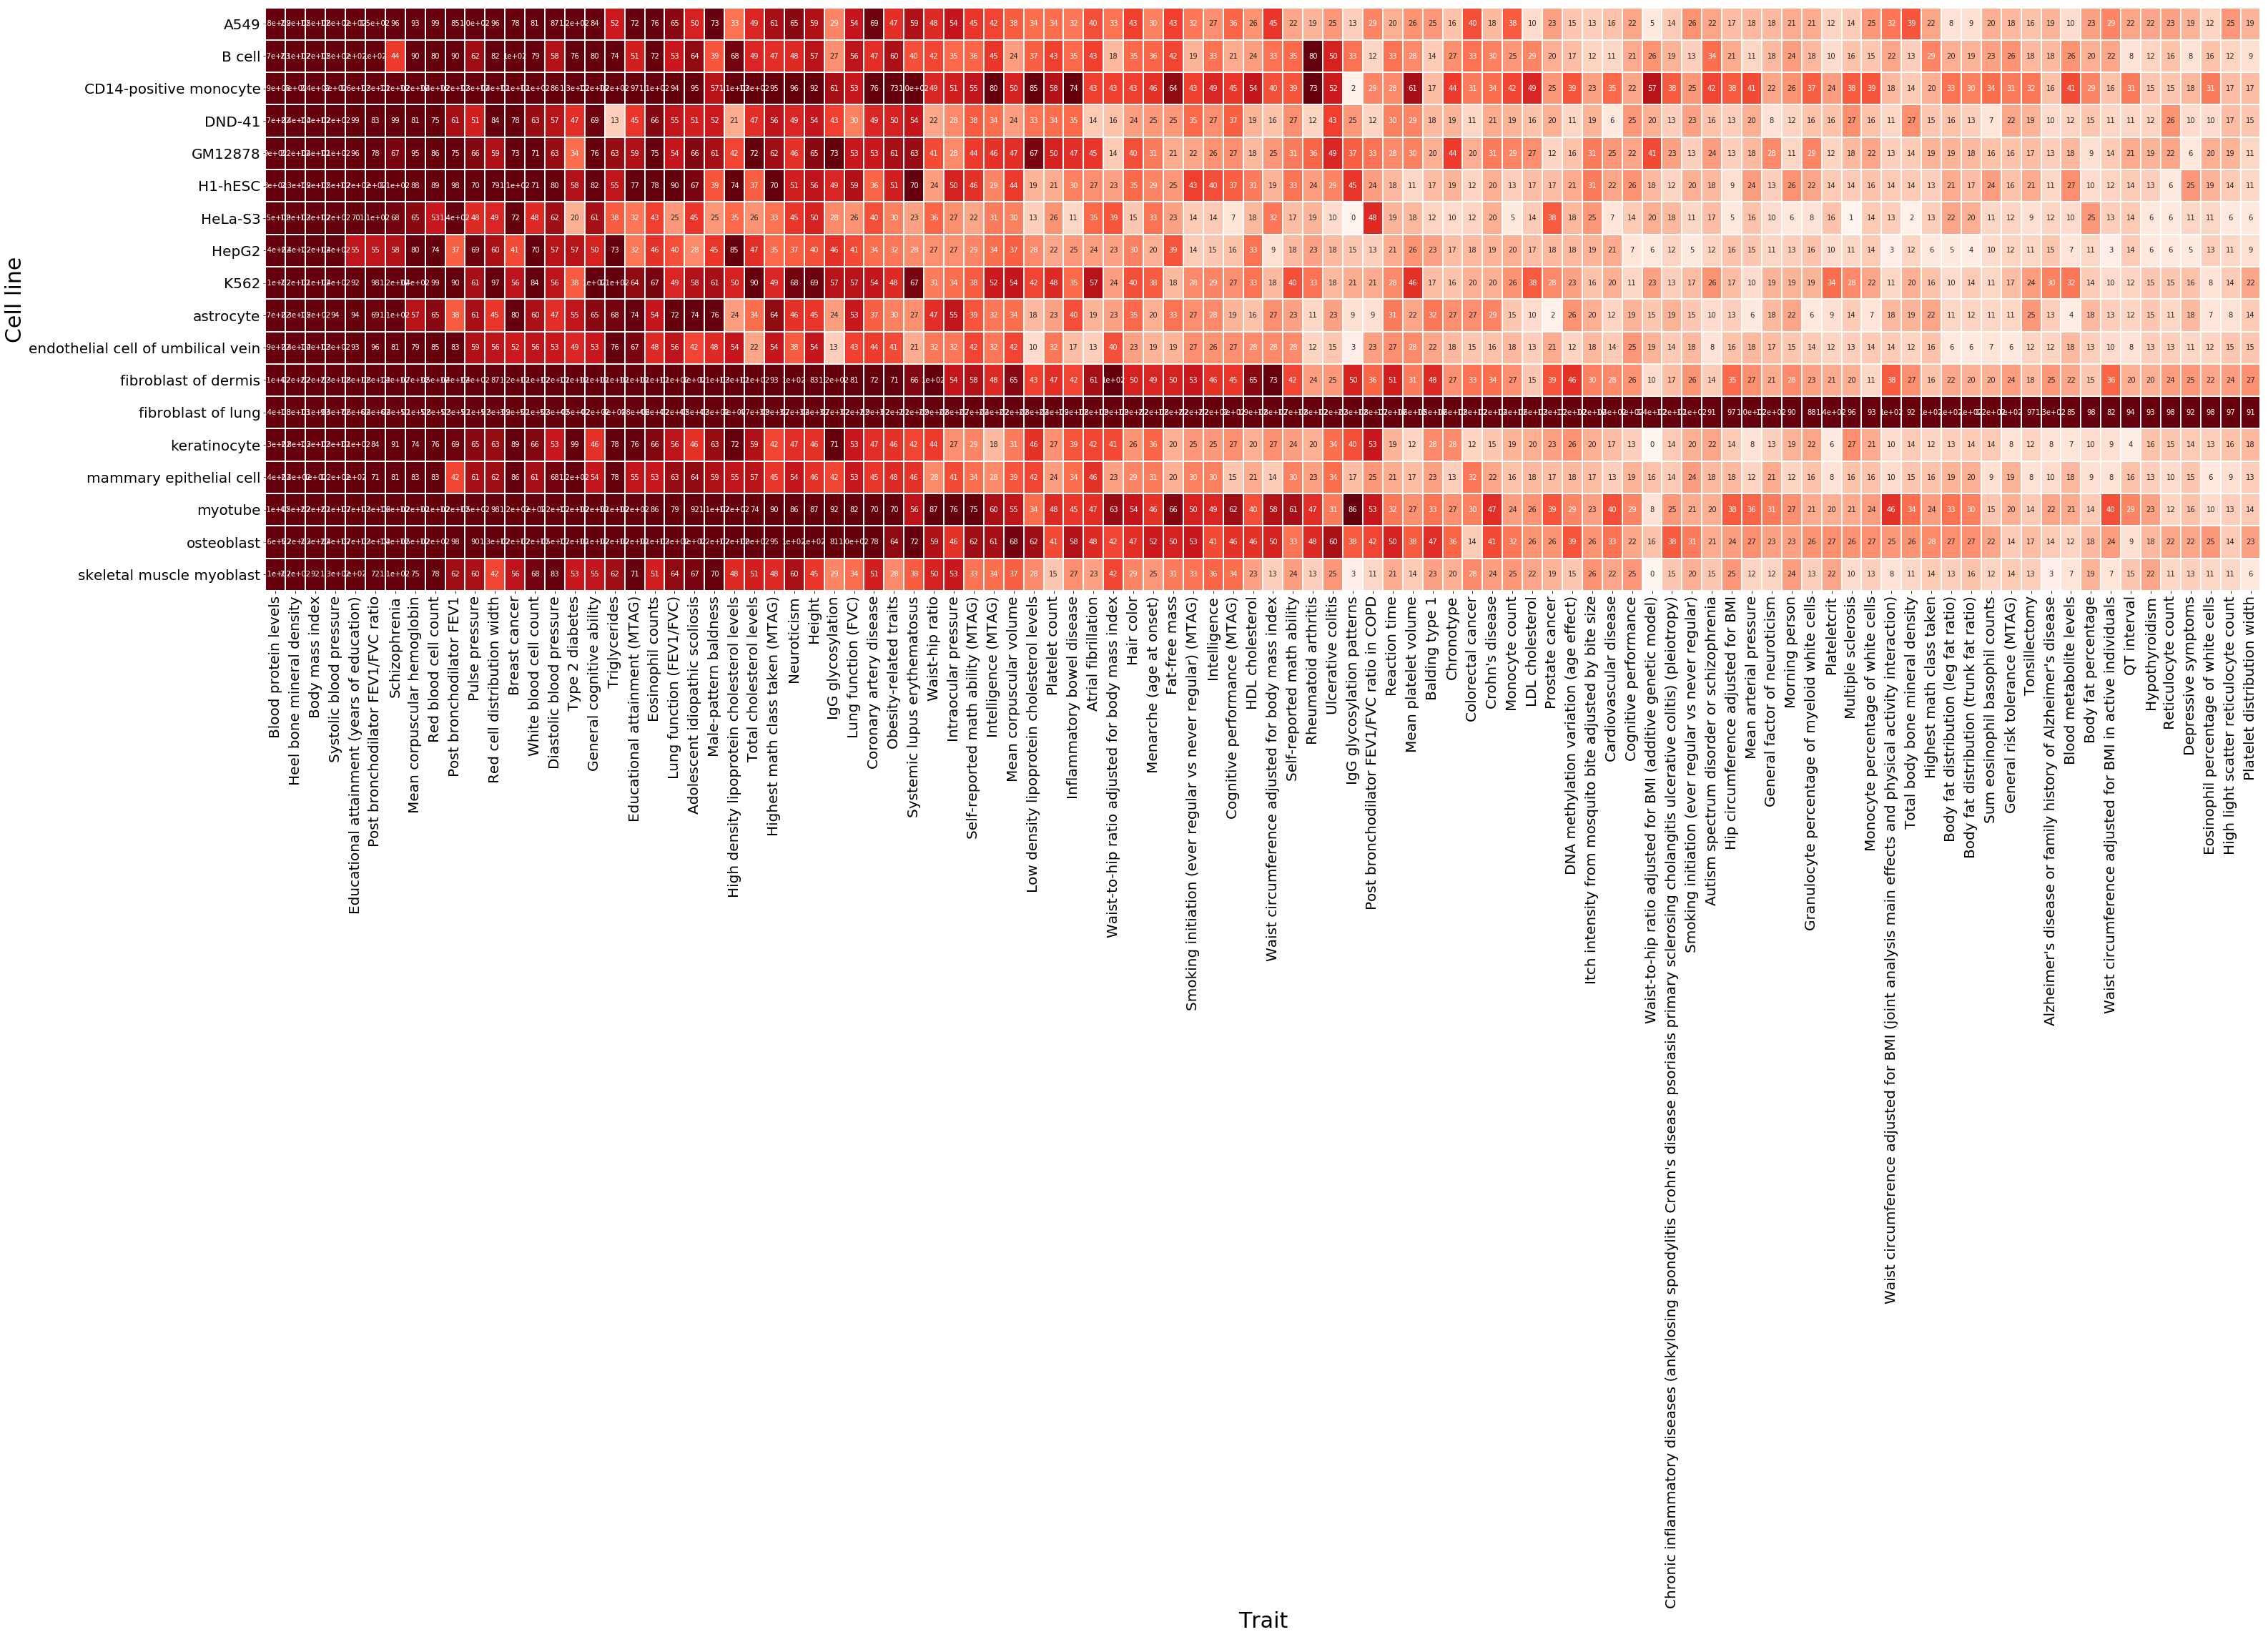

In [27]:
plt.figure(figsize=(50, 15))
sns.heatmap(cross[cross.sum(0).sort_values(ascending=False).iloc[:100].index], cmap='Reds', vmax=70, linewidths=1, annot=True, cbar=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Trait", fontsize=30)
plt.ylabel("Cell line", fontsize=30)
plt.show()